## Armenian Job Postings - Text Mining

### 1. Desired Characteristics and Skill-Sets 

In [1]:
import os
import json
import string
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import wordcloud
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

from sklearn.cluster import KMeans
from sklearn import metrics
import seaborn as sns

import tqdm
import re
import string
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity
import spacy
import scipy
import numpy as np
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_ori = pd.read_csv('C:\\Data_Science\\Certifications\\AnalytixLabs\\Data Science in Python\\Final Projects\\New Projects_TextMining\\6. Analyzing online Job Postings\\data job posts.csv')
df_ori.head()
print(df_ori.shape)
df = df_ori.drop_duplicates(['RequiredQual'])
print(df.shape)
print("Removed {0} duplicates (based on RequiredQual)".format(df_ori.shape[0]-df.shape[0]))

(19001, 24)
(16689, 24)
Removed 2312 duplicates (based on RequiredQual)


In [3]:
df["RequiredQual"].head(10)

0    To perform this job successfully, an\nindividu...
1    - Bachelor's Degree; Master's is preferred;\n-...
2    - Degree in environmentally related field, or ...
3    - Advanced degree in public health, social sci...
4    - University degree; economical background is ...
5    - Candidates should be female, 20-30 years old...
6    - University degree in finance/ accounting; \n...
7                                                  NaN
8    - University degree;\n- At least 3 years of ex...
9    NOTE: All applicants are instructed to\naddres...
Name: RequiredQual, dtype: object

In [4]:
df["RequiredQual"] = df["RequiredQual"].astype(str)

In [5]:
df['RequiredQual_token'] = df['RequiredQual'].map(word_tokenize)

In [6]:
df.RequiredQual_token.head()

0    [To, perform, this, job, successfully, ,, an, ...
1    [-, Bachelor, 's, Degree, ;, Master, 's, is, p...
2    [-, Degree, in, environmentally, related, fiel...
3    [-, Advanced, degree, in, public, health, ,, s...
4    [-, University, degree, ;, economical, backgro...
Name: RequiredQual_token, dtype: object

In [7]:
df.RequiredQual_token[0][:10]


['To',
 'perform',
 'this',
 'job',
 'successfully',
 ',',
 'an',
 'individual',
 'must',
 'be']

In [8]:
df['RequiredQual_len'] = df.RequiredQual_token.apply(len)

In [9]:
df.RequiredQual_len.head()

0    455
1     61
2     47
3    112
4     63
Name: RequiredQual_len, dtype: int64

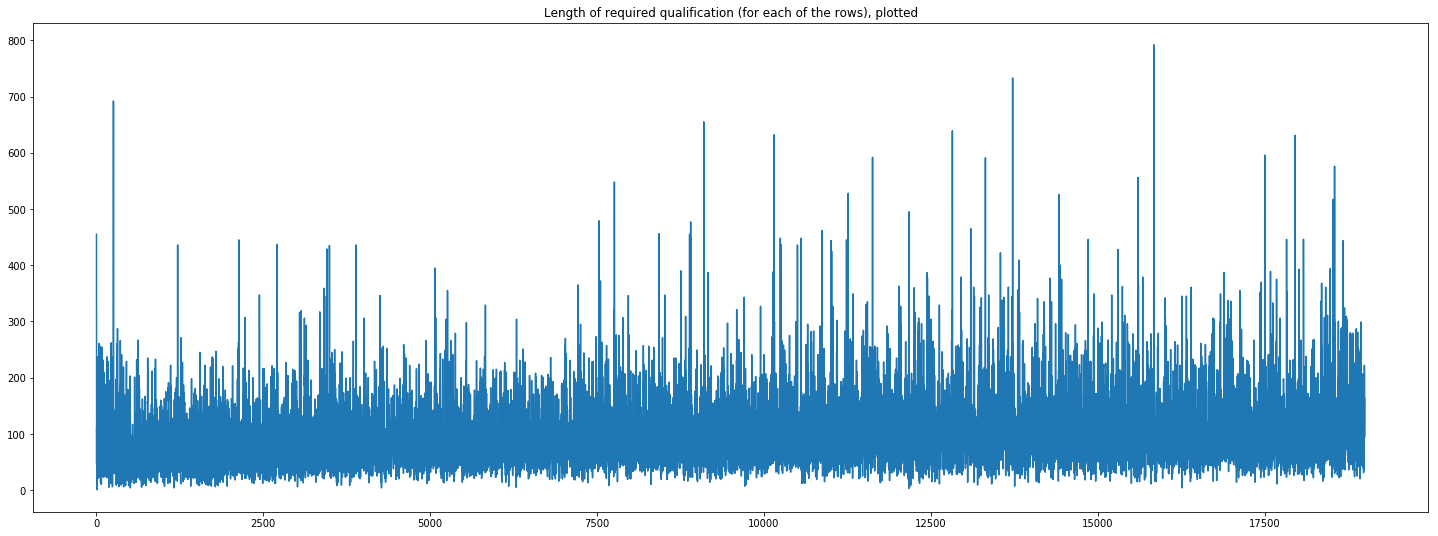

In [10]:
plt.figure(figsize=(25, 9))
plt.plot(df.RequiredQual_len)
plt.title('Length of required qualification (for each of the rows), plotted')
plt.show()

In [11]:
df['RequiredQual_token_uniq'] = df.RequiredQual_token.apply(set)

In [12]:
df['RequiredQual_token_uniq'].head()

0    {accounting, discipline, required, Corporate, ...
1    {work, Past, public, translation, skills, Arme...
2    {or, working, Armenian, 5, -, Russian, environ...
3    {basic, or, public, social, skills, Philippine...
4    {Windows, accepted, be, -, the, degree, softwa...
Name: RequiredQual_token_uniq, dtype: object

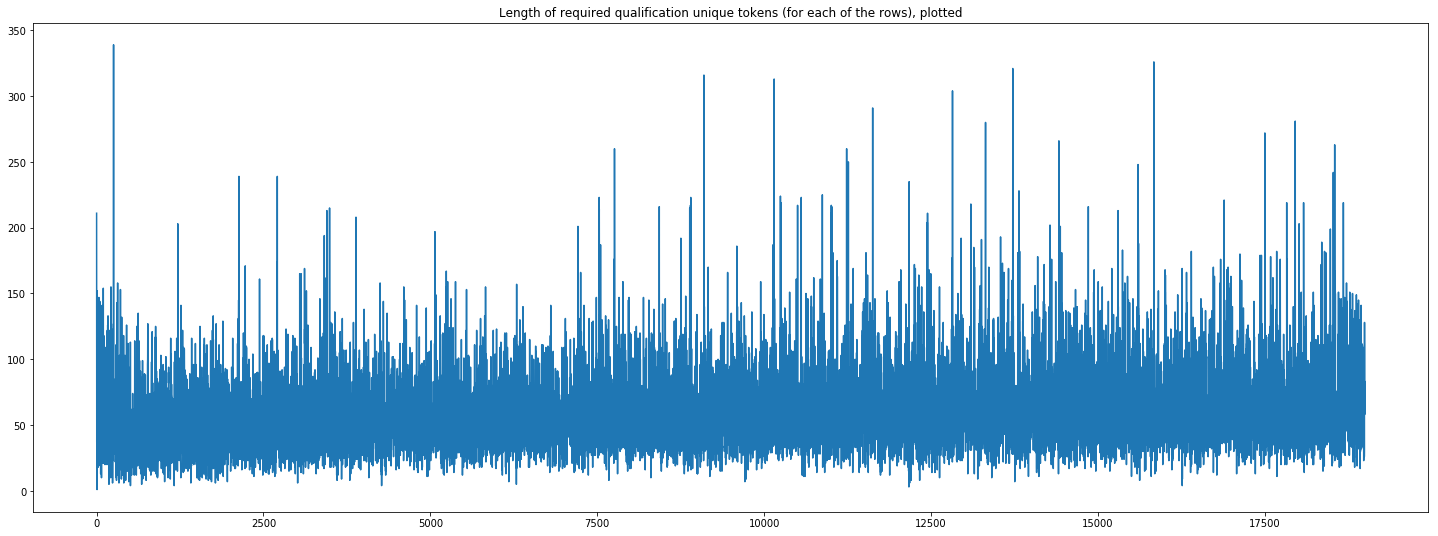

In [13]:
plt.figure(figsize=(25, 9))
plt.plot(df.RequiredQual_token_uniq.apply(len))
plt.title('Length of required qualification unique tokens (for each of the rows), plotted')
plt.show()

Text(0.5,1,'Avg. no. times each word is used (for each of the rows), plotted')

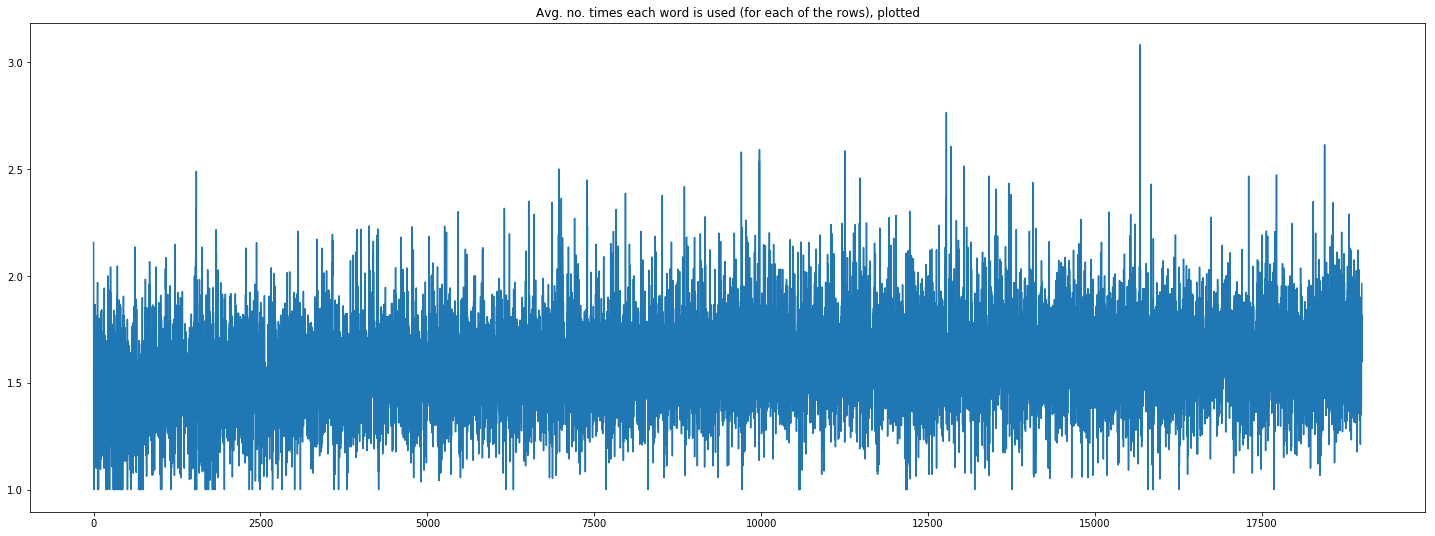

In [14]:
plt.figure(figsize=(25, 9))
plt.plot(df['RequiredQual_len']/df.RequiredQual_token_uniq.apply(len))
plt.title('Avg. no. times each word is used (for each of the rows), plotted')

#### So on average, each word is used 1.5 - 2.5 times in each job posting. 

### Try One Row First, if it works we can make it into a function and apply across the rows

In [15]:
tokens = (df.iloc[0])['RequiredQual_token']

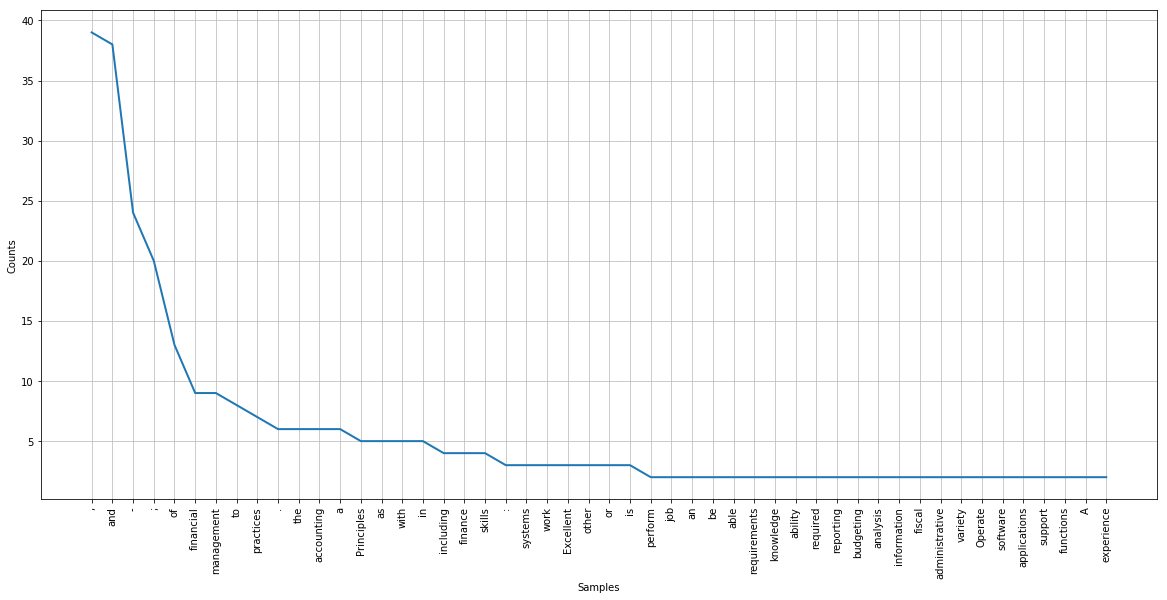

In [16]:
plt.figure(figsize=(20, 9))
fd = nltk.FreqDist(tokens)  # case sensitive!
fd.most_common(50)
fd.plot(50)

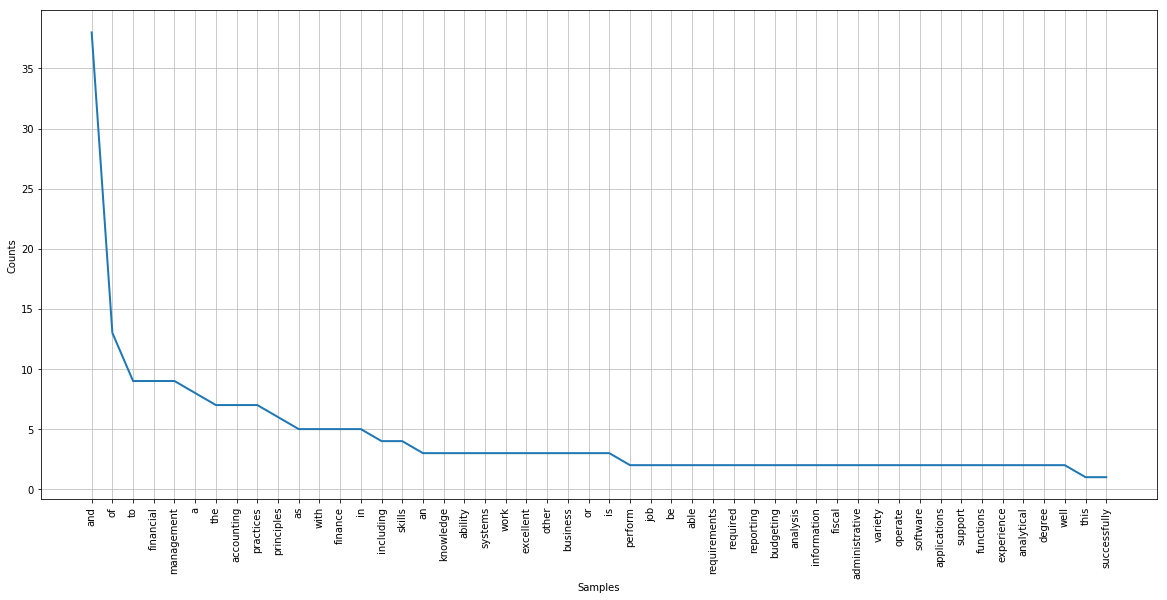

In [17]:
# Remove punctuations, convert all to lower-case, and try again
tokens_nop = [t for t in tokens if t not in string.punctuation]
tokens_nop = [t.lower() for t in tokens_nop]
plt.figure(figsize=(20, 9))
fd = nltk.FreqDist(tokens_nop)  # case sensitive!
fd.most_common(50)
fd.plot(50)

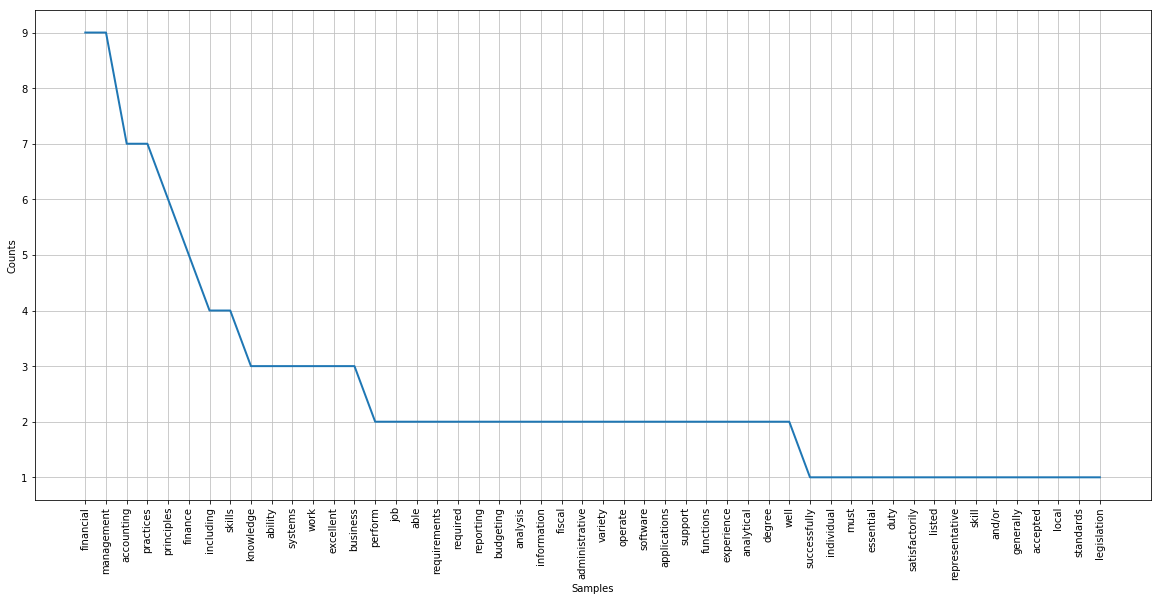

In [18]:
# Remove stopwords, and try again
stop = stopwords.words('english')
tokens_nostop = [t for t in tokens_nop if t not in stop]
plt.figure(figsize=(20, 9))
fd = nltk.FreqDist(tokens_nostop)  # case sensitive!
fd.most_common(50)
fd.plot(50)

In [19]:
print((df.iloc[0])['Title'])

Chief Financial Officer


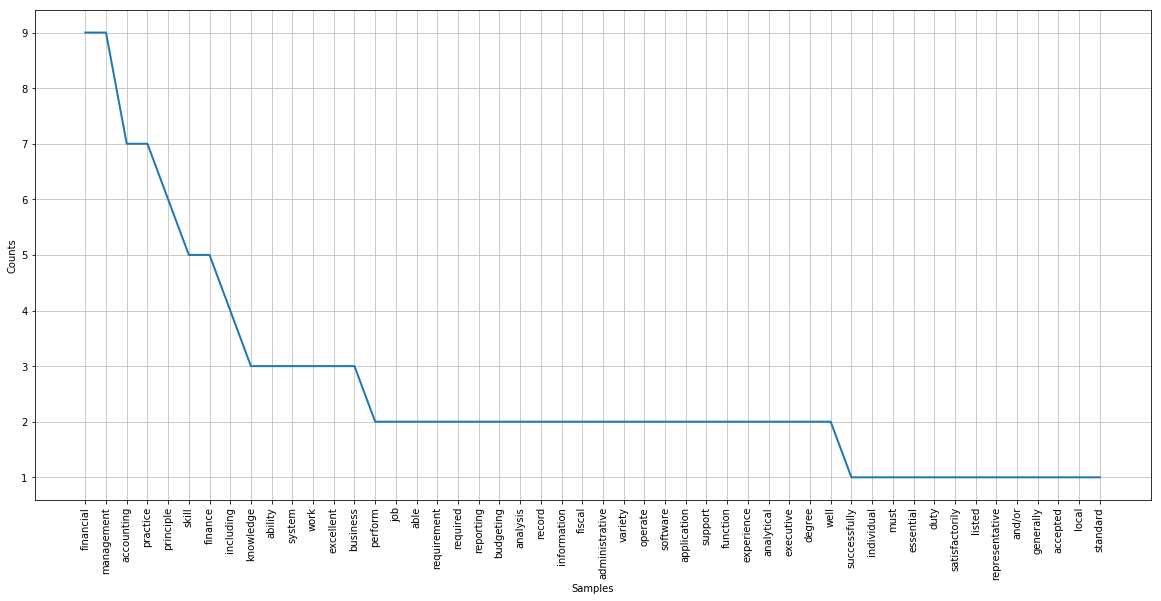

In [20]:
wnl = nltk.WordNetLemmatizer()
tokens_lem = [wnl.lemmatize(t) for t in tokens_nostop]
plt.figure(figsize=(20, 9))
fd = nltk.FreqDist(tokens_lem)  # case sensitive!
fd.most_common(50)
fd.plot(50)

In [21]:
tokens_clean = [t for t in tokens_lem if len(t) >= 3]  # simple way to remove the offending " punctuations
text_clean = " ".join(tokens_clean)


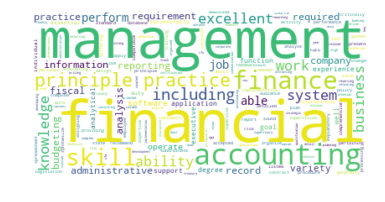

In [22]:
wc = WordCloud(background_color="white").generate(text_clean)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Create a Preprocessing Function for All Rows

In [23]:
def preprocess(tokens):
    tokens_nop = [t for t in tokens if t not in string.punctuation]
    tokens_nop = [t.lower() for t in tokens_nop]
    wnl = nltk.WordNetLemmatizer()
    stop = stopwords.words('english')
    tokens_nostop = [t for t in tokens_nop if t not in stop]
    tokens_lem = [wnl.lemmatize(t) for t in tokens_nostop]
    tokens_clean = [t for t in tokens_lem if len(t) >= 3]  # simple way to remove the offending " punctuations
    return tokens_clean

def plotWC(tokens):
    text_clean = " ".join(tokens)
    print(text_clean)
    wc = WordCloud(background_color="white").generate(text_clean)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    plt.figure(figsize=(20, 9))
    fd = nltk.FreqDist(tokens)  # case sensitive!
    fd.plot(50)

In [24]:
tokens_clean = preprocess((df.iloc[4])['RequiredQual_token']) # we know this is a software job
print(tokens_clean)

['university', 'degree', 'economical', 'background', 'plus', 'excellent', 'knowledge', 'window', '2000', 'server', 'networking', 'tcp/', 'technology', 'sql', '2000', 'server', 'visual', 'basic', 'least', 'year', 'experience', 'database', 'software', 'development', 'good', 'knowledge', 'english', 'remuneration', 'commensurate', 'norm', 'accepted', 'company']


university degree economical background plus excellent knowledge window 2000 server networking tcp/ technology sql 2000 server visual basic least year experience database software development good knowledge english remuneration commensurate norm accepted company


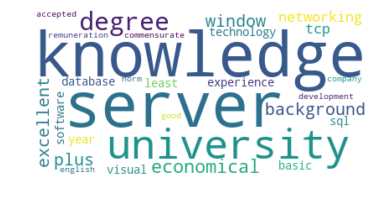

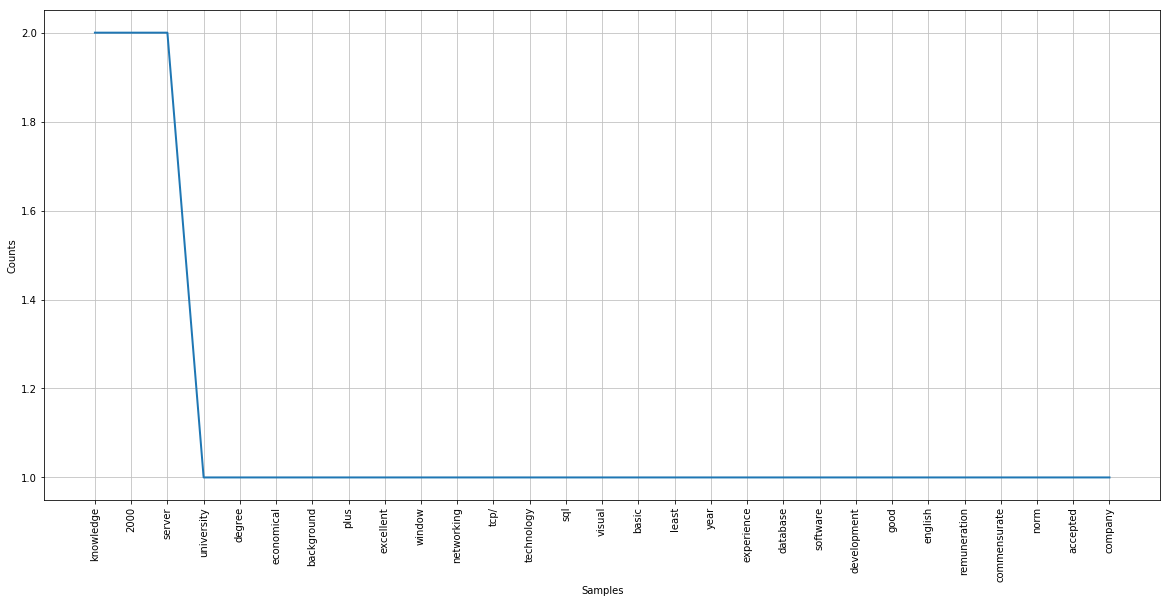

In [25]:
plotWC(tokens_clean)

In [26]:
df['RequiredQual_processed'] = df.RequiredQual_token.apply(preprocess)

In [27]:
df['RequiredQual_processed'].head()

0    [perform, job, successfully, individual, must,...
1    [bachelor, degree, master, preferred, excellen...
2    [degree, environmentally, related, field, year...
3    [advanced, degree, public, health, social, sci...
4    [university, degree, economical, background, p...
Name: RequiredQual_processed, dtype: object

### Get Feature Matrix

In [28]:
df['RequiredQual_processedtext'] = df.RequiredQual_processed.apply(lambda x: ' '.join(x))

In [29]:
vec_tf = CountVectorizer(min_df=2)
required_qual_tf = vec_tf.fit_transform(df['RequiredQual_processedtext'])
print(required_qual_tf.shape)

(16689, 6848)


In [30]:
print(required_qual_tf.toarray())
required_qual_feature_names = (vec_tf.get_feature_names())
required_qual_feature_names[:10]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


['00', '000', '04', '10', '100', '1000', '10g', '11', '11g', '12']

In [31]:
vec_tfidf = TfidfVectorizer(max_df=0.7, min_df=3, use_idf=True)
required_qual_tfidf = vec_tfidf.fit_transform(df['RequiredQual_processedtext'])
print(required_qual_tfidf.shape)

(16689, 5591)


In [32]:
 # To save the vectorized results for future use

pickle.dump(required_qual_tfidf, open("C:\\Data_Science\\Certifications\\AnalytixLabs\\Data Science in Python\\Final Projects\\New Projects_TextMining\\6. Analyzing online Job Postings\\output\\required_qual_tfidf.pkl", "wb"))
pickle.dump(vec_tfidf.vocabulary_, open("C:\\Data_Science\\Certifications\\AnalytixLabs\\Data Science in Python\\Final Projects\\New Projects_TextMining\\6. Analyzing online Job Postings\\output\\required_qual_tfidf_features.pkl", "wb"))


Try clustering


In [33]:
# Use SVD to reduce dimensions
svd = TruncatedSVD(1500)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X_lsa = lsa.fit_transform(required_qual_tfidf)

In [34]:
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Explained variance of the SVD step: 89%


In [35]:

num_clusters = 7

for num in [num_clusters]:
    km3 = KMeans(n_clusters=num, init='k-means++', max_iter=1000, n_init=1, random_state=1)
    %time km3.fit(X_lsa)
    # The higher the better (-1 to 1)
    print("Clusters: {0}".format(num))
    print("Silhouette Coefficient for clusters: %0.3f"
          % metrics.silhouette_score(X_lsa, km3.labels_))

Wall time: 4.65 s
Clusters: 7
Silhouette Coefficient for clusters: 0.013


In [36]:
def print_terms(cm, num):
    original_space_centroids = svd.inverse_transform(cm.cluster_centers_)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    terms = vec_tfidf.get_feature_names()
    for i in range(num):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

print_terms(km3, num_clusters)

Cluster 0: net sql web development good server javascript database html php
Cluster 1: ability management work degree year good excellent project field armenian
Cluster 2: higher education work russian excellent armenian good computer field ability
Cluster 3: accounting finance armenian tax work financial legislation good excellent standard
Cluster 4: marketing sale business excellent ability work russian communication strong degree
Cluster 5: development testing software design good programming ability plus tool linux
Cluster 6: work excellent ability armenian russian good university communication degree strong


In [37]:
df["RequiredQual"].head()

0    To perform this job successfully, an\nindividu...
1    - Bachelor's Degree; Master's is preferred;\n-...
2    - Degree in environmentally related field, or ...
3    - Advanced degree in public health, social sci...
4    - University degree; economical background is ...
Name: RequiredQual, dtype: object

In [38]:
df["date"].head()

0     Jan 5, 2004
1     Jan 7, 2004
2     Jan 7, 2004
3     Jan 7, 2004
4    Jan 10, 2004
Name: date, dtype: object

In [39]:
def get_year_from_date_if_exists(date_str):
    year_str = date_str.strip()[-4:]
    for c in year_str:
        if c.isalpha():
            return "0"
    
    return year_str

df["year"] = df["date"].apply(get_year_from_date_if_exists)
df["year"].head()

0    2004
1    2004
2    2004
3    2004
4    2004
Name: year, dtype: object

In [40]:
df = df[df["year"] != "0"]

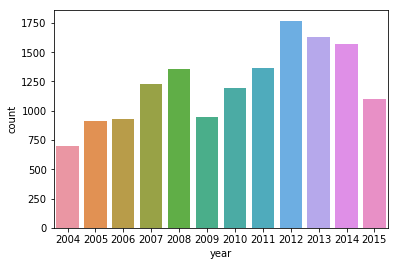

In [41]:

ax = sns.countplot(x="year", data=df)
ax

In [42]:
def set_group_by_year(year):
    year = int(year)
    if year >= 2004 and year <= 2007:
        return 1
    elif year >= 2008 and year <= 2011:
        return 2
    else:
        return 3
    
df["year_group"] = df["year"].apply(set_group_by_year)

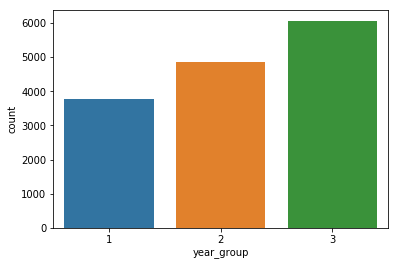

In [43]:
ax = sns.countplot(x="year_group", data=df)
ax

In [44]:
df1 = df[df["year_group"] == 1]
df2 = df[df["year_group"] == 2]
df3 = df[df["year_group"] == 3]

In [45]:
# For each data frame create the TF_IDF matrix, perform SVD decomposition and then KMeans cluster
year_wise_dfs = [df1, df2, df3]
CLUSTERS = 7

for idx, year_wise_df in enumerate(year_wise_dfs):
    print("Year group: {0}".format(idx))
    
    # create the TF-IDF matrix
    vec_tfidf = TfidfVectorizer(max_df=0.7, min_df=3, use_idf=True)
    required_qual_tfidf = vec_tfidf.fit_transform(year_wise_df['RequiredQual_processedtext'])
    
    # Use SVD to reduce dimensions
    svd = TruncatedSVD(1000)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    X_lsa = lsa.fit_transform(required_qual_tfidf)
    
    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))
    
    # KMeans clustering
    km3 = KMeans(n_clusters=CLUSTERS, init='k-means++', max_iter=1000, n_init=1, random_state=1)
    km3.fit(X_lsa)
    
    # The higher the better (-1 to 1)
    print("Clusters: {0}".format(CLUSTERS))
    print("Silhouette Coefficient for clusters: %0.3f"
          % metrics.silhouette_score(X_lsa, km3.labels_))
    
    print_terms(km3, CLUSTERS)

Year group: 0
Explained variance of the SVD step: 93%
Clusters: 7
Silhouette Coefficient for clusters: 0.015
Cluster 0: development sql net java web server programming software work year
Cluster 1: skill excellent work armenian good russian communication ability university degree
Cluster 2: year relevant field work degree university driving least good plus
Cluster 3: ability design skill work good system technical photoshop plus network
Cluster 4: skill management ability project work degree international strong excellent year
Cluster 5: higher education skill excellent work russian armenian good computer field
Cluster 6: accounting finance financial standard armenian software tax work good year
Year group: 1
Explained variance of the SVD step: 90%
Clusters: 7
Silhouette Coefficient for clusters: 0.016
Cluster 0: good ability work degree plus network year university computer engineering
Cluster 1: work excellent ability russian university degree armenian communication office strong
Clu

### 2. Similarity of Jobs

In [46]:
#nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

In [47]:
df_job_related = df[['Title','JobDescription','RequiredQual','JobRequirment']]

In [48]:
df_job_related.head(10)

,Title,JobDescription,RequiredQual,JobRequirment
0,Chief Financial Officer,AMERIA Investment Consulting Company is seekin...,"To perform this job successfully, an\nindividu...",- Supervises financial management and administ...
1,Full-time Community Connections Intern (paid i...,NaN,- Bachelor's Degree; Master's is preferred;\n-...,NaN
2,Country Coordinator,Public outreach and strengthening of a growing...,"- Degree in environmentally related field, or ...",- Working with the Country Director to provide...
3,BCC Specialist,The LEAD (Local Enhancement and Development fo...,"- Advanced degree in public health, social sci...",- Identify gaps in knowledge and overseeing in...
4,Software Developer,NaN,- University degree; economical background is ...,- Rendering technical assistance to Database M...
5,Saleswoman,Saleswoman will sell menswear and accessories.,"- Candidates should be female, 20-30 years old...",NaN
6,Chief Accountant/ Finance Assistant,The Armenian Branch Office of the Open Society...,- University degree in finance/ accounting; \n...,NaN
7,Non-paid part or full time Programmatic Intern,NaN,nan,NaN
8,Assistant to Managing Director,NaN,- University degree;\n- At least 3 years of ex...,- Coordinating the work of subordinate employe...
9,"Program Assistant (INL), FSN-8; FP-6*",The incumbent assists in coordinating INL-fund...,NOTE: All applicants are instructed to\naddres...,NaN


In [49]:
df_job_related['JobDescription'] = df_job_related['JobDescription'].astype(str)
df_job_related['RequiredQual'] = df_job_related['RequiredQual'].astype(str)
df_job_related['JobRequirment'] = df_job_related['JobRequirment'].astype(str)
df_job_related['Title'] = df_job_related['Title'].astype(str)

In [50]:
df_job_related['JobDescription_token'] = df_job_related['JobDescription'].map(word_tokenize)
df_job_related['RequiredQual_token'] = df_job_related['RequiredQual'].map(word_tokenize)
df_job_related['JobRequirment_token'] = df_job_related['JobRequirment'].map(word_tokenize)

### Remove punctuations and stopwords from the above tokens

In [51]:
# stopwords and punctuation removal
df_job_related['JobDescription_token'] = df_job_related['JobDescription_token'].apply(lambda x: [item for item in x if item not in stop_words])
df_job_related['JobDescription_token'] = df_job_related['JobDescription_token'].apply(lambda x: [item for item in x if item not in string.punctuation])
df_job_related['RequiredQual_token'] = df_job_related['RequiredQual_token'].apply(lambda x: [item for item in x if item not in stop_words])
df_job_related['RequiredQual_token'] = df_job_related['RequiredQual_token'].apply(lambda x: [item for item in x if item not in string.punctuation])
df_job_related['JobRequirment_token'] = df_job_related['JobRequirment_token'].apply(lambda x: [item for item in x if item not in stop_words])
df_job_related['JobRequirment_token'] = df_job_related['JobRequirment_token'].apply(lambda x: [item for item in x if item not in string.punctuation])

In [52]:
# lowercase
df_job_related['JobDescription_token'] = df_job_related['JobDescription_token'].apply(lambda x: [item.lower() for item in x])
df_job_related['RequiredQual_token'] = df_job_related['RequiredQual_token'].apply(lambda x: [item.lower() for item in x])
df_job_related['JobRequirment_token'] = df_job_related['JobRequirment_token'].apply(lambda x: [item.lower() for item in x])

In [53]:
# stem
df_job_related['JobDescription_token'] = df_job_related['JobDescription_token'].apply(lambda x: [PorterStemmer().stem(item) for item in x])
df_job_related['RequiredQual_token'] = df_job_related['RequiredQual_token'].apply(lambda x: [PorterStemmer().stem(item) for item in x])
df_job_related['JobRequirment_token'] = df_job_related['JobRequirment_token'].apply(lambda x: [PorterStemmer().stem(item) for item in x])

In [54]:
# convert list to string
df_job_related['JobDescription_token_str'] = df_job_related['JobDescription_token'].apply(lambda x: " ".join(x))
df_job_related['RequiredQual_token_str'] = df_job_related['RequiredQual_token'].apply(lambda x: " ".join(x))
df_job_related['JobRequirment_token_str'] = df_job_related['JobRequirment_token'].apply(lambda x: " ".join(x))

In [55]:
df_job_related.head(10)

,Title,JobDescription,RequiredQual,JobRequirment,JobDescription_token,RequiredQual_token,JobRequirment_token,JobDescription_token_str,RequiredQual_token_str,JobRequirment_token_str
0,Chief Financial Officer,AMERIA Investment Consulting Company is seekin...,"To perform this job successfully, an\nindividu...",- Supervises financial management and administ...,"[ameria, invest, consult, compani, seek, chief...","[to, perform, job, success, individu, must, ab...","[supervis, financi, manag, administr, staff, i...",ameria invest consult compani seek chief finan...,to perform job success individu must abl perfo...,supervis financi manag administr staff includ ...
1,Full-time Community Connections Intern (paid i...,nan,- Bachelor's Degree; Master's is preferred;\n-...,nan,[nan],"[bachelor, 's, degre, master, 's, prefer, exce...",[nan],nan,bachelor 's degre master 's prefer excel skill...,nan
2,Country Coordinator,Public outreach and strengthening of a growing...,"- Degree in environmentally related field, or ...",- Working with the Country Director to provide...,"[public, outreach, strengthen, grow, network, ...","[degre, environment, relat, field, 5, year, re...","[work, countri, director, provid, environment,...",public outreach strengthen grow network enviro...,degre environment relat field 5 year relev exp...,work countri director provid environment infor...
3,BCC Specialist,The LEAD (Local Enhancement and Development fo...,"- Advanced degree in public health, social sci...",- Identify gaps in knowledge and overseeing in...,"[the, lead, local, enhanc, develop, health, bc...","[advanc, degre, public, health, social, scienc...","[identifi, gap, knowledg, overse, inform, coll...",the lead local enhanc develop health bcc speci...,advanc degre public health social scienc commu...,identifi gap knowledg overse inform collect fi...
4,Software Developer,nan,- University degree; economical background is ...,- Rendering technical assistance to Database M...,[nan],"[univers, degre, econom, background, plu, exce...","[render, technic, assist, databas, manag, syst...",nan,univers degre econom background plu excel know...,render technic assist databas manag system rea...
5,Saleswoman,Saleswoman will sell menswear and accessories.,"- Candidates should be female, 20-30 years old...",nan,"[saleswoman, sell, menswear, accessori]","[candid, femal, 20-30, year, old, nice-look, e...",[nan],saleswoman sell menswear accessori,candid femal 20-30 year old nice-look exterior...,nan
6,Chief Accountant/ Finance Assistant,The Armenian Branch Office of the Open Society...,- University degree in finance/ accounting; \n...,nan,"[the, armenian, branch, offic, open, societi, ...","[univers, degre, finance/, account, one, year,...",[nan],the armenian branch offic open societi institu...,univers degre finance/ account one year minimu...,nan
7,Non-paid part or full time Programmatic Intern,nan,nan,nan,[nan],[nan],[nan],nan,nan,nan
8,Assistant to Managing Director,nan,- University degree;\n- At least 3 years of ex...,- Coordinating the work of subordinate employe...,[nan],"[univers, degre, at, least, 3, year, experi, r...","[coordin, work, subordin, employe, maintain, l...",nan,univers degre at least 3 year experi relev fie...,coordin work subordin employe maintain liaison...
9,"Program Assistant (INL), FSN-8; FP-6*",The incumbent assists in coordinating INL-fund...,NOTE: All applicants are instructed to\naddres...,nan,"[the, incumb, assist, coordin, inl-fund, law, ...","[note, all, applic, instruct, address, select,...",[nan],the incumb assist coordin inl-fund law enforc ...,note all applic instruct address select criter...,nan


### TF-IDF based similarity

In [56]:
tfidf_model = TfidfVectorizer()
Title_tfidf = tfidf_model.fit_transform(df_job_related['Title'])
JobDescription_tfidf = tfidf_model.fit_transform(df_job_related['JobDescription_token_str'])
RequiredQual_tfidf = tfidf_model.fit_transform(df_job_related['RequiredQual_token_str'])
JobRequirment_tfidf = tfidf_model.fit_transform(df_job_related['JobRequirment_token_str'])

In [57]:
def find_similar_jobs_tfidf(index, top_n = 5):
    Title_tfidf_cosine = cosine_similarity(Title_tfidf[index:index+1], Title_tfidf).flatten()
    JobDescription_tfidf_cosine = cosine_similarity(JobDescription_tfidf[index:index+1], JobDescription_tfidf).flatten()
    RequiredQual_tfidf_cosine = cosine_similarity(RequiredQual_tfidf[index:index+1], RequiredQual_tfidf).flatten()
    JobRequirment_tfidf_cosine = cosine_similarity(JobRequirment_tfidf[index:index+1], JobRequirment_tfidf).flatten()

    average_cosine = (Title_tfidf_cosine + JobDescription_tfidf_cosine + RequiredQual_tfidf_cosine + JobRequirment_tfidf_cosine) / 4.0
    related_docs_indices = [i for i in average_cosine.argsort()[::-1] if i != index]
    return [(index, average_cosine[index]) for index in related_docs_indices][0:top_n]

In [58]:
df_job_related.iloc[0]

Title                                                 Chief Financial Officer
JobDescription              AMERIA Investment Consulting Company is seekin...
RequiredQual                To perform this job successfully, an\nindividu...
JobRequirment               - Supervises financial management and administ...
JobDescription_token        [ameria, invest, consult, compani, seek, chief...
RequiredQual_token          [to, perform, job, success, individu, must, ab...
JobRequirment_token         [supervis, financi, manag, administr, staff, i...
JobDescription_token_str    ameria invest consult compani seek chief finan...
RequiredQual_token_str      to perform job success individu must abl perfo...
JobRequirment_token_str     supervis financi manag administr staff includ ...
Name: 0, dtype: object

In [59]:
for index, score in find_similar_jobs_tfidf(0):
    print(df_job_related.iloc[index])
    print("SIMILARITY SCORE: ", score)

Title                                                 Chief Financial Officer
JobDescription              River Island is seeking a Chief Financial Offi...
RequiredQual                - Master's degree in Management, Finance or Ec...
JobRequirment               - Develop tools and systems to provide critica...
JobDescription_token        [river, island, seek, chief, financi, offic, r...
RequiredQual_token          [master, 's, degre, manag, financ, econom, at,...
JobRequirment_token         [develop, tool, system, provid, critic, financ...
JobDescription_token_str    river island seek chief financi offic respons ...
RequiredQual_token_str      master 's degre manag financ econom at least 5...
JobRequirment_token_str     develop tool system provid critic financi oper...
Name: 11223, dtype: object
SIMILARITY SCORE:  0.48834784391725516
Title                                                 Chief Financial Officer
JobDescription              The Chief Financial Officer (CFO) will support..

In [60]:
df_job_related.iloc[1]

Title                       Full-time Community Connections Intern (paid i...
JobDescription                                                            nan
RequiredQual                - Bachelor's Degree; Master's is preferred;\n-...
JobRequirment                                                             nan
JobDescription_token                                                    [nan]
RequiredQual_token          [bachelor, 's, degre, master, 's, prefer, exce...
JobRequirment_token                                                     [nan]
JobDescription_token_str                                                  nan
RequiredQual_token_str      bachelor 's degre master 's prefer excel skill...
JobRequirment_token_str                                                   nan
Name: 1, dtype: object

In [61]:
for index, score in find_similar_jobs_tfidf(1):
    print(df_job_related.iloc[index])
    print("SIMILARITY SCORE: ", score)

Title                                                 IT Teacher  (full time)
JobDescription                                                            nan
RequiredQual                - Degree in Computer Science, Information Tech...
JobRequirment                                                             nan
JobDescription_token                                                    [nan]
RequiredQual_token          [degre, comput, scienc, inform, technolog, rel...
JobRequirment_token                                                     [nan]
JobDescription_token_str                                                  nan
RequiredQual_token_str      degre comput scienc inform technolog relat dis...
JobRequirment_token_str                                                   nan
Name: 114, dtype: object
SIMILARITY SCORE:  0.658779743834556
Title                                  Administrative and Programmatic Intern
JobDescription                                                            nan
Re

In [62]:
df_job_related.iloc[2]

Title                                                     Country Coordinator
JobDescription              Public outreach and strengthening of a growing...
RequiredQual                - Degree in environmentally related field, or ...
JobRequirment               - Working with the Country Director to provide...
JobDescription_token        [public, outreach, strengthen, grow, network, ...
RequiredQual_token          [degre, environment, relat, field, 5, year, re...
JobRequirment_token         [work, countri, director, provid, environment,...
JobDescription_token_str    public outreach strengthen grow network enviro...
RequiredQual_token_str      degre environment relat field 5 year relev exp...
JobRequirment_token_str     work countri director provid environment infor...
Name: 2, dtype: object

In [63]:
for index, score in find_similar_jobs_tfidf(2):
    print(df_job_related.iloc[index])
    print("SIMILARITY SCORE: ", score)

Title                                           Country Coordinator - Armenia
JobDescription              CENN - Caucasus Environmental NGO Network - is...
RequiredQual                1. Education: University education in environm...
JobRequirment               -  Write first hand articles, conduct intervie...
JobDescription_token        [cenn, caucasu, environment, ngo, network, loo...
RequiredQual_token          [1, educ, univers, educ, environment, scienc, ...
JobRequirment_token         [write, first, hand, articl, conduct, intervie...
JobDescription_token_str    cenn caucasu environment ngo network look coun...
RequiredQual_token_str      1 educ univers educ environment scienc relat f...
JobRequirment_token_str     write first hand articl conduct interview coll...
Name: 404, dtype: object
SIMILARITY SCORE:  0.4578933960787438
Title                                                     Country Coordinator
JobDescription              Veya Limited needs an experienced Business Man...
R

### Word and Doc Vectors

In [64]:
# 1. Using online pretrained model
# https://spacy.io/models/en#en_core_web_lg

In [65]:
import en_core_web_lg

In [66]:
# to download model
#!python -m spacy download en_core_web_lg

nlp = spacy.load('en_core_web_lg')

Note:
Similarity is determined by comparing word vectors or "word embeddings", multi-dimensional meaning representations of a word. https://spacy.io/usage/spacy-101#vectors-similarity

Similarity in Spacy is computed by:

return numpy.dot(self.vector, other.vector) / (self.vector_norm * other.vector_norm)
This looks like its the formula for computing cosine similarity and the vectors seem to be created with SpaCy's .vector which documentation says is trained from GloVe's w2v model. https://spacy.io/api/token#similarity

From the spacy website:

Models that come with built-in word vectors make them available as the Token.vector attribute. Doc.vector and Span.vector will default to an average of their token vectors.

Generate a final similarity score between two documents at a time, by comparing against,
Titles
Job Description
Job Requirements
Required Qualification
Note:
The out of the box pretrained word embedding model gives decent results for Titles.

But for other fields where the sentence vector is obtained by simply averaging word vectors alone, the pretrained word embedding model was not able to distinguish well for RequiredQual, JobDescription and JobRequirment, regardless of the full string or using tokens after punctuation and stopwords removal.

For most of the job comparisons, it gave high similarity score (>0.8)

In [67]:
# e.g. Original text - Title
doc1 = nlp(df_job_related.iloc[0]['Title'])
doc2 = nlp(df_job_related.iloc[2]['Title'])
similarity = doc1.similarity(doc2)
print("DOC1:\n" + doc1.text, "\n\nDOC2:\n", doc2.text, "\n\n", similarity)

DOC1:
Chief Financial Officer 

DOC2:
 Country Coordinator 

 0.537330015139695


In [68]:
# e.g. Original text - RequiredQual
doc1 = nlp(df_job_related.iloc[0]['RequiredQual'])
doc2 = nlp(df_job_related.iloc[2]['RequiredQual'])
similarity = doc1.similarity(doc2)
print("DOC1:\n" + doc1.text, "\n\nDOC2:\n", doc2.text, "\n\n", similarity)

DOC1:
To perform this job successfully, an
individual must be able to perform each essential duty satisfactorily.
The requirements listed below are representative of the knowledge,
skill, and/or ability required.
Knowledge of:
- Generally accepted accounting principles;
- Local accounting standards and legislation;
- State reporting requirements pertaining to accounting;
- Principles and practices of financial management and budgeting;
- Principles and practices of financial systems design and analysis;
- Principles and practices of contract management, records management,
and risk management;
- Principles and practices of management and supervision;
- Principles and practices of information systems management.
Ability to:
- Apply sound fiscal and administrative practices to the company's
activities;
- Plan, organize and supervise the work of subordinate employees,
including training them, assigning and evaluating their work, and
providing job performance feedback;
- Critically analyze

In [69]:
# E.g. removing stopwords and punctuations
doc1 = nlp(SPACE.join(df_job_related.iloc[0]['RequiredQual_token']))
doc2 = nlp(SPACE.join(df_job_related.iloc[2]['RequiredQual_token']))
similarity = doc1.similarity(doc2)
print("DOC1:\n" + doc1.text, "\n\nDOC2:\n", doc2.text, "\n\n", similarity)

NameError: name 'SPACE' is not defined

Extracting keywords using POS and Regex Matcher

In [71]:
from spacy.matcher import Matcher
from spacy import displacy

def collect_sents(matcher, doc, i, matches):
    match_id, start, end = matches[i]
    span = doc[start : end]  # matched span
    sent = span.sent  # sentence containing matched span
    # append mock entity for match in displaCy style to matched_sents
    # get the match span by ofsetting the start and end of the span with the
    # start and end of the sentence in the doc
    match_ents = [{'start': span.start_char - sent.start_char,
                   'end': span.end_char - sent.start_char,
                   'label': 'MATCH'}]
    matched_sents.append({'text': sent.text, 'ents': match_ents })

matcher = Matcher(nlp.vocab)
matched_sents = []

pattern = [{'POS':'ADJ'},{'ORTH': '-'}, {'POS':'NOUN', 'OP':'+'}, {'LOWER': 'organization'}]
matcher.add('company has', collect_sents, pattern)  # add pattern
pattern = [{'POS':'NOUN', 'OP':'+'}, {'LOWER': 'organization'}]
matcher.add('company has', collect_sents, pattern)  # add pattern
pattern = [{'POS':'NOUN', 'OP':'+'}, {'LOWER': 'company'}]
matcher.add('company has', collect_sents, pattern)  # add pattern
pattern = [{'POS':'NOUN', 'OP':'+'}, {'LOWER': 'services'}]
matcher.add('company has', collect_sents, pattern)  # add pattern
pattern = [{'LOWER': 'company'}, {'POS':'VERB'}, {'POS':'NOUN', 'OP':'+'}]
matcher.add('company has', collect_sents, pattern)  # add pattern
pattern = [{'LOWER':'provider'}, {'POS':'ADP'}, {'POS':'NOUN',  'OP': '+'}  , {'POS':'CCONJ','OP':'+'}, {'POS':'NOUN','OP':'+'}]
matcher.add('provider of', collect_sents, pattern)  # add pattern
pattern = [{'LOWER':'provider'}, {'POS':'ADP'}, {'POS':'NOUN',  'OP': '+'}]
matcher.add('provider of', collect_sents, pattern)  # add pattern
pattern = [{'POS':'VERB'}, {'POS':'NOUN',  'OP': '+'} ]
matcher.add('verb_noun', collect_sents, pattern)  # add pattern
pattern = [{'POS':'ADJ'}, {'POS':'NOUN',  'OP': '+'} ]
matcher.add('verb_noun', collect_sents, pattern)  # add pattern
pattern = [{'POS':'NOUN'}, {'POS':'ADP'}, {'POS':'NOUN',  'OP': '+'} ]
matcher.add('verb_noun', collect_sents, pattern)  # add pattern
pattern = [{'POS':'NOUN'}, {'POS':'NOUN','OP':'+'} ]
matcher.add('verb_noun', collect_sents, pattern)  # add pattern

In [72]:
SPACE = " "
for job1_idx in range(df_job_related.shape[0]):
    matched_sents = []
    keywords = []
    text = re.sub(r'\s+', ' ', df_job_related.iloc[job1_idx]['RequiredQual'])
    doc = nlp(text)
    matches = matcher(doc)
    for match_id, start, end in matches:
        string_id = nlp.vocab.strings[match_id]  # get string representation
        span = doc[start:end]  # the matched span
        keywords.append(span.text)
    df_job_related.set_value(job1_idx, 'RequiredQual_keywords', SPACE.join(keywords))

In [73]:
for job1_idx in range(df_job_related.shape[0]):
    matched_sents = []
    keywords = []
    text = re.sub(r'\s+', ' ', df_job_related.iloc[job1_idx]['JobDescription'])
    doc = nlp(text)
    matches = matcher(doc)
    for match_id, start, end in matches:
        string_id = nlp.vocab.strings[match_id]  # get string representation
        span = doc[start:end]  # the matched span
        keywords.append(span.text)
    df_job_related.set_value(job1_idx, 'JobDescription_keywords', SPACE.join(keywords))

TypeError: expected string or bytes-like object

In [74]:
for job1_idx in range(df_job_related.shape[0]):
    matched_sents = []
    keywords = []
    text = re.sub(r'\s+', ' ', df_job_related.iloc[job1_idx]['JobRequirment'])
    doc = nlp(text)
    matches = matcher(doc)
    for match_id, start, end in matches:
        string_id = nlp.vocab.strings[match_id]  # get string representation
        span = doc[start:end]  # the matched span
        keywords.append(span.text)
    df_job_related.set_value(job1_idx, 'JobRequirment_keywords', SPACE.join(keywords))

TypeError: expected string or bytes-like object

In [75]:
# matched keywords highlighted - example for job 0
displacy.render(matched_sents, style='ent', manual=True, jupyter=True)

In [76]:
# keywords from the sentence - example for job 0
keywords

[]

In [77]:
df_job_related.head(10)

,Title,JobDescription,RequiredQual,JobRequirment,JobDescription_token,RequiredQual_token,JobRequirment_token,JobDescription_token_str,RequiredQual_token_str,JobRequirment_token_str,RequiredQual_keywords,JobDescription_keywords,JobRequirment_keywords
0,Chief Financial Officer,AMERIA Investment Consulting Company is seekin...,"To perform this job successfully, an\nindividu...",- Supervises financial management and administ...,"[ameria, invest, consult, compani, seek, chief...","[to, perform, job, success, individu, must, ab...","[supervis, financi, manag, administr, staff, i...",ameria invest consult compani seek chief finan...,to perform job success individu must abl perfo...,supervis financi manag administr staff includ ...,essential duty accepted accounting accepted ac...,administrative functions complex staff complex...,financial management administrative staff assi...
1,Full-time Community Connections Intern (paid i...,nan,- Bachelor's Degree; Master's is preferred;\n-...,nan,[nan],"[bachelor, 's, degre, master, 's, prefer, exce...",[nan],nan,bachelor 's degre master 's prefer excel skill...,nan,Excellent skills Armenian languages Armenian t...,,
2,Country Coordinator,Public outreach and strengthening of a growing...,"- Degree in environmentally related field, or ...",- Working with the Country Director to provide...,"[public, outreach, strengthen, grow, network, ...","[degre, environment, relat, field, 5, year, re...","[work, countri, director, provid, environment,...",public outreach strengthen grow network enviro...,degre environment relat field 5 year relev exp...,work countri director provid environment infor...,related field relevant experience written flue...,Public outreach growing network international ...,environmental information general public elect...
3,BCC Specialist,The LEAD (Local Enhancement and Development fo...,"- Advanced degree in public health, social sci...",- Identify gaps in knowledge and overseeing in...,"[the, lead, local, enhanc, develop, health, bc...","[advanc, degre, public, health, social, scienc...","[identifi, gap, knowledg, overse, inform, coll...",the lead local enhanc develop health bcc speci...,advanc degre public health social scienc commu...,identifi gap knowledg overse inform collect fi...,Advanced degree public health social science r...,apply state art approaches address provider ca...,Identify gaps gaps in knowledge overseeing inf...
4,Software Developer,nan,- University degree; economical background is ...,- Rendering technical assistance to Database M...,[nan],"[univers, degre, econom, background, plu, exce...","[render, technic, assist, databas, manag, syst...",nan,univers degre econom background plu excel know...,render technic assist databas manag system rea...,University degree economical background Excell...,,technical assistance servers maintenance serve...
5,Saleswoman,Saleswoman will sell menswear and accessories.,"- Candidates should be female, 20-30 years old...",nan,"[saleswoman, sell, menswear, accessori]","[candid, femal, 20-30, year, old, nice-look, e...",[nan],saleswoman sell menswear accessori,candid femal 20-30 year old nice-look exterior...,nan,looking exterior Excellent communication Excel...,sell menswear,
6,Chief Accountant/ Finance Assistant,The Armenian Branch Office of the Open Society...,- University degree in finance/ accounting; \n...,nan,"[the, armenian, branch, offic, open, societi, ...","[univers, degre, finance/, account, one, year,...",[nan],the armenian branch offic open societi institu...,univers degre finance/ account one year minimu...,nan,University degree degree in finance/ degree in...,seeking applications grant payments administra...,
7,Non-paid part or full time Programmatic Intern,nan,nan,nan,[nan],[nan],[nan],nan,nan,nan,,,
8,Assistant to Managing Director,nan,- University degree;\n- At least 3 years of ex...,- Coordinating the work of subordinate employe...,[nan],"[univers, degre, at, least, 3, year, experi, r...","[coordin, work, subo

In [78]:
# optional - saving df to disk for future
df_job_related.to_csv("job_similarity_df_with_keywords.csv", index=False, sep='\t')

Create a job-similarity matrix storing the values of similarity(cosine) scores between two jobs
Note:
Computing 1 vs 19K jobs takes 1 hour.

Computing entire matrix will not be feasible.

Hence only 3 jobs were selected for this operation and restricted to first 1000 jobs.

In [79]:
# iterate through each row vs rest of rows to calculate DIS-similarity

job_dissimilarity_df = pd.DataFrame(columns=['index', 'similar-job', 'dissimilar-score'])

for job1_idx in range(3):  # rows
    for job2_idx in range(1000):

        doc1 = nlp(df_job_related.iloc[job1_idx]['Title'])
        doc2 = nlp(df_job_related.iloc[job2_idx]['Title'])
        title_similarity = doc1.similarity(doc2)
        
        doc1 = nlp(df_job_related.iloc[job1_idx]['JobDescription_keywords'])
        doc2 = nlp(df_job_related.iloc[job2_idx]['JobDescription_keywords'])
        jd_similarity = doc1.similarity(doc2)
        
        doc1 = nlp(df_job_related.iloc[job1_idx]['JobRequirment_keywords'])
        doc2 = nlp(df_job_related.iloc[job2_idx]['JobRequirment_keywords'])
        jr_similarity = doc1.similarity(doc2)
        
        doc1 = nlp(df_job_related.iloc[job1_idx]['RequiredQual_keywords'])
        doc2 = nlp(df_job_related.iloc[job2_idx]['RequiredQual_keywords'])
        rq_similarity = doc1.similarity(doc2)
        
        averaged_score = (title_similarity + jd_similarity + jr_similarity + rq_similarity) / 4.0
        job_dissimilarity_df = job_dissimilarity_df.append({'index': job1_idx, 'similar-job': job2_idx, 'dissimilar-score': (1-averaged_score)},ignore_index=True)

In [80]:
job_dissimilarity_df.head(10)

,index,similar-job,dissimilar-score
0,0.0,0.0,0.000000
1,0.0,1.0,0.702536
2,0.0,2.0,0.252482
3,0.0,3.0,0.276024
4,0.0,4.0,0.479441
5,0.0,5.0,0.707513
6,0.0,6.0,0.359552
7,0.0,7.0,0.874434
8,0.0,8.0,0.381022
9,0.0,9.0,0.468250


Show top similar jobs

In [81]:
job_dissimilarity_df_sorted = job_dissimilarity_df.sort_values(by=['index', 'dissimilar-score'], ascending=[True, True])

In [82]:
job_dissimilarity_df_sorted.head(10)

,index,similar-job,dissimilar-score
0,0.0,0.0,0.000000
323,0.0,323.0,0.117383
98,0.0,98.0,0.129504
630,0.0,630.0,0.138544
216,0.0,216.0,0.138831
102,0.0,102.0,0.143089
605,0.0,605.0,0.143711
832,0.0,832.0,0.145559
722,0.0,722.0,0.145564
551,0.0,551.0,0.146702


In [83]:
# Show top 5 similar results to job - Chief Financial Officer
similar_jobs = job_dissimilarity_df_sorted.loc[job_dissimilarity_df_sorted['index'] == 0].head(6)['similar-job'].tolist()

for job in similar_jobs:
    print(df_job_related.iloc[int(job)].replace(r'\n',' ', regex=True))

Title                                                 Chief Financial Officer
JobDescription              AMERIA Investment Consulting Company is seekin...
RequiredQual                To perform this job successfully, an individua...
JobRequirment               - Supervises financial management and administ...
JobDescription_token        [ameria, invest, consult, compani, seek, chief...
RequiredQual_token          [to, perform, job, success, individu, must, ab...
JobRequirment_token         [supervis, financi, manag, administr, staff, i...
JobDescription_token_str    ameria invest consult compani seek chief finan...
RequiredQual_token_str      to perform job success individu must abl perfo...
JobRequirment_token_str     supervis financi manag administr staff includ ...
RequiredQual_keywords       essential duty accepted accounting accepted ac...
JobDescription_keywords     administrative functions complex staff complex...
JobRequirment_keywords      financial management administrative 

In [84]:
# Show top 5 similar results to job - Country Coordinator
similar_jobs = job_dissimilarity_df_sorted.loc[job_dissimilarity_df_sorted['index'] == 2].head(6)['similar-job'].tolist()

for job in similar_jobs:
    print(df_job_related.iloc[int(job)])

Title                                                     Country Coordinator
JobDescription              Public outreach and strengthening of a growing...
RequiredQual                - Degree in environmentally related field, or ...
JobRequirment               - Working with the Country Director to provide...
JobDescription_token        [public, outreach, strengthen, grow, network, ...
RequiredQual_token          [degre, environment, relat, field, 5, year, re...
JobRequirment_token         [work, countri, director, provid, environment,...
JobDescription_token_str    public outreach strengthen grow network enviro...
RequiredQual_token_str      degre environment relat field 5 year relev exp...
JobRequirment_token_str     work countri director provid environment infor...
RequiredQual_keywords       related field relevant experience written flue...
JobDescription_keywords     Public outreach growing network international ...
JobRequirment_keywords      environmental information general pu

2. Using custom Doc2Vec

In [91]:
from gensim.models.doc2vec import Doc2Vec

filename = "C:\\Data_Science\\Certifications\\AnalytixLabs\\Data Science in Python\\Final Projects\\New Projects_TextMining\\6. Analyzing online Job Postings\\Original Solution GitHub\\classification\\models\\doc2vec_model_trained_300"
d2vmodel = Doc2Vec.load(filename)

##Keeping original columns


In [92]:
# iterate through each row vs rest of rows to calculate DIS-similarity

job_dissimilarity_d2v_df = pd.DataFrame(columns=['index', 'similar-job', 'dissimilar-score'])

for job1_idx in range(3):  # rows
    for job2_idx in range(1000):
        title_similarity = 1- scipy.spatial.distance.cosine(d2vmodel.infer_vector(df_job_related.iloc[job1_idx]['Title'].split()), d2vmodel.infer_vector(df_job_related.iloc[job2_idx]['Title'].split()))
        jd_similarity = 1- scipy.spatial.distance.cosine(d2vmodel.infer_vector(df_job_related.iloc[job1_idx]['JobDescription'].split()), d2vmodel.infer_vector(df_job_related.iloc[job2_idx]['JobDescription'].split()))
        jr_similarity = 1- scipy.spatial.distance.cosine(d2vmodel.infer_vector(df_job_related.iloc[job1_idx]['JobRequirment'].split()), d2vmodel.infer_vector(df_job_related.iloc[job2_idx]['JobRequirment'].split()))
        rq_similarity = 1- scipy.spatial.distance.cosine(d2vmodel.infer_vector(df_job_related.iloc[job1_idx]['RequiredQual'].split()), d2vmodel.infer_vector(df_job_related.iloc[job2_idx]['RequiredQual'].split()))

        averaged_score = (title_similarity + jd_similarity + jr_similarity + rq_similarity) / 4.0
        job_dissimilarity_d2v_df = job_dissimilarity_d2v_df.append({'index': job1_idx, 'similar-job': job2_idx, 'dissimilar-score': (1-averaged_score)},ignore_index=True)

In [93]:
job_dissimilarity_d2v_df_sorted = job_dissimilarity_d2v_df.sort_values(by=['index', 'dissimilar-score'], ascending=[True, True])

In [94]:
job_dissimilarity_d2v_df_sorted.head(10)

,index,similar-job,dissimilar-score
0,0.0,0.0,0.007872
551,0.0,551.0,0.501216
30,0.0,30.0,0.706151
712,0.0,712.0,0.720127
993,0.0,993.0,0.722847
759,0.0,759.0,0.726914
172,0.0,172.0,0.727741
312,0.0,312.0,0.730489
304,0.0,304.0,0.731681
135,0.0,135.0,0.736789


In [95]:
# Show top 5 similar results to job - Chief Financial Officer
similar_jobs = job_dissimilarity_d2v_df_sorted.loc[job_dissimilarity_d2v_df_sorted['index'] == 0].head(6)['similar-job'].tolist()

for job in similar_jobs:
    print(df_job_related.iloc[int(job)])

Title                                                 Chief Financial Officer
JobDescription              AMERIA Investment Consulting Company is seekin...
RequiredQual                To perform this job successfully, an\nindividu...
JobRequirment               - Supervises financial management and administ...
JobDescription_token        [ameria, invest, consult, compani, seek, chief...
RequiredQual_token          [to, perform, job, success, individu, must, ab...
JobRequirment_token         [supervis, financi, manag, administr, staff, i...
JobDescription_token_str    ameria invest consult compani seek chief finan...
RequiredQual_token_str      to perform job success individu must abl perfo...
JobRequirment_token_str     supervis financi manag administr staff includ ...
RequiredQual_keywords       essential duty accepted accounting accepted ac...
JobDescription_keywords     administrative functions complex staff complex...
JobRequirment_keywords      financial management administrative 

In [96]:
# Show top 5 similar results to job - Intern
similar_jobs = job_dissimilarity_d2v_df_sorted.loc[job_dissimilarity_d2v_df_sorted['index'] == 1].head(6)['similar-job'].tolist()

for job in similar_jobs:
    print(df_job_related.iloc[int(job)])

Title                       Full-time Community Connections Intern (paid i...
JobDescription                                                            nan
RequiredQual                - Bachelor's Degree; Master's is preferred;\n-...
JobRequirment                                                             nan
JobDescription_token                                                    [nan]
RequiredQual_token          [bachelor, 's, degre, master, 's, prefer, exce...
JobRequirment_token                                                     [nan]
JobDescription_token_str                                                  nan
RequiredQual_token_str      bachelor 's degre master 's prefer excel skill...
JobRequirment_token_str                                                   nan
RequiredQual_keywords       Excellent skills Armenian languages Armenian t...
JobDescription_keywords                                                      
JobRequirment_keywords                                          

In [97]:
# Show top 5 similar results to job - Country Coordinator
similar_jobs = job_dissimilarity_d2v_df_sorted.loc[job_dissimilarity_d2v_df_sorted['index'] == 2].head(6)['similar-job'].tolist()

for job in similar_jobs:
    print(df_job_related.iloc[int(job)])

Title                                                     Country Coordinator
JobDescription              Public outreach and strengthening of a growing...
RequiredQual                - Degree in environmentally related field, or ...
JobRequirment               - Working with the Country Director to provide...
JobDescription_token        [public, outreach, strengthen, grow, network, ...
RequiredQual_token          [degre, environment, relat, field, 5, year, re...
JobRequirment_token         [work, countri, director, provid, environment,...
JobDescription_token_str    public outreach strengthen grow network enviro...
RequiredQual_token_str      degre environment relat field 5 year relev exp...
JobRequirment_token_str     work countri director provid environment infor...
RequiredQual_keywords       related field relevant experience written flue...
JobDescription_keywords     Public outreach growing network international ...
JobRequirment_keywords      environmental information general pu

Using only the keywords

In [98]:
# iterate through each row vs rest of rows to calculate DIS-similarity

job_dissimilarity_d2v_df = pd.DataFrame(columns=['index', 'similar-job', 'dissimilar-score'])

for job1_idx in range(3):  # rows
    for job2_idx in range(1000):
        title_similarity = 1- scipy.spatial.distance.cosine(d2vmodel.infer_vector(df_job_related.iloc[job1_idx]['Title'].split()), d2vmodel.infer_vector(df_job_related.iloc[job2_idx]['Title'].split()))
        jd_similarity = 1- scipy.spatial.distance.cosine(d2vmodel.infer_vector(df_job_related.iloc[job1_idx]['JobDescription_keywords'].split()), d2vmodel.infer_vector(df_job_related.iloc[job2_idx]['JobDescription_keywords'].split()))
        jr_similarity = 1- scipy.spatial.distance.cosine(d2vmodel.infer_vector(df_job_related.iloc[job1_idx]['JobRequirment_keywords'].split()), d2vmodel.infer_vector(df_job_related.iloc[job2_idx]['JobRequirment_keywords'].split()))
        rq_similarity = 1- scipy.spatial.distance.cosine(d2vmodel.infer_vector(df_job_related.iloc[job1_idx]['RequiredQual_keywords'].split()), d2vmodel.infer_vector(df_job_related.iloc[job2_idx]['RequiredQual_keywords'].split()))

        averaged_score = (title_similarity + jd_similarity + jr_similarity + rq_similarity) / 4.0
        job_dissimilarity_d2v_df = job_dissimilarity_d2v_df.append({'index': job1_idx, 'similar-job': job2_idx, 'dissimilar-score': (1-averaged_score)},ignore_index=True)

In [99]:
job_dissimilarity_d2v_df_sorted = job_dissimilarity_d2v_df.sort_values(by=['index', 'dissimilar-score'], ascending=[True, True])

In [100]:
# Show top 5 similar results to job - Chief Financial Officer
similar_jobs = job_dissimilarity_d2v_df_sorted.loc[job_dissimilarity_d2v_df_sorted['index'] == 0].head(6)['similar-job'].tolist()

for job in similar_jobs:
    print(df_job_related.iloc[int(job)])

Title                                                 Chief Financial Officer
JobDescription              AMERIA Investment Consulting Company is seekin...
RequiredQual                To perform this job successfully, an\nindividu...
JobRequirment               - Supervises financial management and administ...
JobDescription_token        [ameria, invest, consult, compani, seek, chief...
RequiredQual_token          [to, perform, job, success, individu, must, ab...
JobRequirment_token         [supervis, financi, manag, administr, staff, i...
JobDescription_token_str    ameria invest consult compani seek chief finan...
RequiredQual_token_str      to perform job success individu must abl perfo...
JobRequirment_token_str     supervis financi manag administr staff includ ...
RequiredQual_keywords       essential duty accepted accounting accepted ac...
JobDescription_keywords     administrative functions complex staff complex...
JobRequirment_keywords      financial management administrative 

In [101]:
# Show top 5 similar results to job - Intern
similar_jobs = job_dissimilarity_d2v_df_sorted.loc[job_dissimilarity_d2v_df_sorted['index'] == 1].head(6)['similar-job'].tolist()

for job in similar_jobs:
    print(df_job_related.iloc[int(job)])

Title                       Full-time Community Connections Intern (paid i...
JobDescription                                                            nan
RequiredQual                - Bachelor's Degree; Master's is preferred;\n-...
JobRequirment                                                             nan
JobDescription_token                                                    [nan]
RequiredQual_token          [bachelor, 's, degre, master, 's, prefer, exce...
JobRequirment_token                                                     [nan]
JobDescription_token_str                                                  nan
RequiredQual_token_str      bachelor 's degre master 's prefer excel skill...
JobRequirment_token_str                                                   nan
RequiredQual_keywords       Excellent skills Armenian languages Armenian t...
JobDescription_keywords                                                      
JobRequirment_keywords                                          

In [102]:
# Show top 5 similar results to job - Coordinator
similar_jobs = job_dissimilarity_d2v_df_sorted.loc[job_dissimilarity_d2v_df_sorted['index'] == 2].head(6)['similar-job'].tolist()

for job in similar_jobs:
    print(df_job_related.iloc[int(job)])

Title                                                     Country Coordinator
JobDescription              Public outreach and strengthening of a growing...
RequiredQual                - Degree in environmentally related field, or ...
JobRequirment               - Working with the Country Director to provide...
JobDescription_token        [public, outreach, strengthen, grow, network, ...
RequiredQual_token          [degre, environment, relat, field, 5, year, re...
JobRequirment_token         [work, countri, director, provid, environment,...
JobDescription_token_str    public outreach strengthen grow network enviro...
RequiredQual_token_str      degre environment relat field 5 year relev exp...
JobRequirment_token_str     work countri director provid environment infor...
RequiredQual_keywords       related field relevant experience written flue...
JobDescription_keywords     Public outreach growing network international ...
JobRequirment_keywords      environmental information general pu

In [103]:
# iterate through each row vs rest of rows to calculate DIS-similarity

job_dissimilarity_d2v_df = pd.DataFrame(columns=['index', 'similar-job', 'dissimilar-score'])

for job1_idx in range(3):  # rows
    for job2_idx in range(1000):
        title_similarity = 1- scipy.spatial.distance.cosine(d2vmodel.infer_vector(df_job_related.iloc[job1_idx]['Title'].split()), d2vmodel.infer_vector(df_job_related.iloc[job2_idx]['Title'].split()))
        jd_similarity = 1- scipy.spatial.distance.cosine(d2vmodel.infer_vector(df_job_related.iloc[job1_idx]['JobDescription'].split()), d2vmodel.infer_vector(df_job_related.iloc[job2_idx]['JobDescription'].split()))
        jr_similarity = 1- scipy.spatial.distance.cosine(d2vmodel.infer_vector(df_job_related.iloc[job1_idx]['JobRequirment'].split()), d2vmodel.infer_vector(df_job_related.iloc[job2_idx]['JobRequirment'].split()))
        rq_similarity = 1- scipy.spatial.distance.cosine(d2vmodel.infer_vector(df_job_related.iloc[job1_idx]['RequiredQual'].split()), d2vmodel.infer_vector(df_job_related.iloc[job2_idx]['RequiredQual'].split()))

        averaged_score = (title_similarity*0.9 + jd_similarity*0.3 + jr_similarity*0.3 + rq_similarity*0.3) / 4.0
        job_dissimilarity_d2v_df = job_dissimilarity_d2v_df.append({'index': job1_idx, 'similar-job': job2_idx, 'dissimilar-score': (1-averaged_score)},ignore_index=True)

In [104]:
job_dissimilarity_d2v_df_sorted = job_dissimilarity_d2v_df.sort_values(by=['index', 'dissimilar-score'], ascending=[True, True])

In [105]:
job_dissimilarity_d2v_df_sorted.head(10)

,index,similar-job,dissimilar-score
0,0.0,0.0,0.552409
551,0.0,551.0,0.699598
30,0.0,30.0,0.898694
312,0.0,312.0,0.899846
712,0.0,712.0,0.902645
977,0.0,977.0,0.903198
958,0.0,958.0,0.905495
172,0.0,172.0,0.905856
993,0.0,993.0,0.905899
879,0.0,879.0,0.907071


In [106]:
# Show top 5 similar results to job - Chief Financial Officer
similar_jobs = job_dissimilarity_d2v_df_sorted.loc[job_dissimilarity_d2v_df_sorted['index'] == 0].head(6)['similar-job'].tolist()

for job in similar_jobs:
    print(df_job_related.iloc[int(job)])

Title                                                 Chief Financial Officer
JobDescription              AMERIA Investment Consulting Company is seekin...
RequiredQual                To perform this job successfully, an\nindividu...
JobRequirment               - Supervises financial management and administ...
JobDescription_token        [ameria, invest, consult, compani, seek, chief...
RequiredQual_token          [to, perform, job, success, individu, must, ab...
JobRequirment_token         [supervis, financi, manag, administr, staff, i...
JobDescription_token_str    ameria invest consult compani seek chief finan...
RequiredQual_token_str      to perform job success individu must abl perfo...
JobRequirment_token_str     supervis financi manag administr staff includ ...
RequiredQual_keywords       essential duty accepted accounting accepted ac...
JobDescription_keywords     administrative functions complex staff complex...
JobRequirment_keywords      financial management administrative 

In [107]:
# Show top 5 similar results to job - Intern
similar_jobs = job_dissimilarity_d2v_df_sorted.loc[job_dissimilarity_d2v_df_sorted['index'] == 1].head(6)['similar-job'].tolist()

for job in similar_jobs:
    print(df_job_related.iloc[int(job)])

Title                       Full-time Community Connections Intern (paid i...
JobDescription                                                            nan
RequiredQual                - Bachelor's Degree; Master's is preferred;\n-...
JobRequirment                                                             nan
JobDescription_token                                                    [nan]
RequiredQual_token          [bachelor, 's, degre, master, 's, prefer, exce...
JobRequirment_token                                                     [nan]
JobDescription_token_str                                                  nan
RequiredQual_token_str      bachelor 's degre master 's prefer excel skill...
JobRequirment_token_str                                                   nan
RequiredQual_keywords       Excellent skills Armenian languages Armenian t...
JobDescription_keywords                                                      
JobRequirment_keywords                                          

In [108]:
# Show top 5 similar results to job - Country Coordinator
similar_jobs = job_dissimilarity_d2v_df_sorted.loc[job_dissimilarity_d2v_df_sorted['index'] == 2].head(6)['similar-job'].tolist()

for job in similar_jobs:
    print(df_job_related.iloc[int(job)])

Title                                                     Country Coordinator
JobDescription              Public outreach and strengthening of a growing...
RequiredQual                - Degree in environmentally related field, or ...
JobRequirment               - Working with the Country Director to provide...
JobDescription_token        [public, outreach, strengthen, grow, network, ...
RequiredQual_token          [degre, environment, relat, field, 5, year, re...
JobRequirment_token         [work, countri, director, provid, environment,...
JobDescription_token_str    public outreach strengthen grow network enviro...
RequiredQual_token_str      degre environment relat field 5 year relev exp...
JobRequirment_token_str     work countri director provid environment infor...
RequiredQual_keywords       related field relevant experience written flue...
JobDescription_keywords     Public outreach growing network international ...
JobRequirment_keywords      environmental information general pu

### 3. Classification 
### Doc2Vec with SVM for Binary Classification




In [110]:
import gensim
import os
import collections
import smart_open
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

RANDOM_STATE = 41

In [111]:
df = pd.read_csv('C:\\Data_Science\\Certifications\AnalytixLabs\Data Science in Python\\Final Projects\\New Projects_TextMining\\6. Analyzing online Job Postings\\Original Solution GitHub\\data\\data_jobposts_it.csv')

df['text'] = df.jobpost.apply(gensim.utils.simple_preprocess)
df["label"] = df.IT
df = df[["text", "label"]]
df.head(5)

,text,label
0,"[ameria, investment, consulting, company, job,...",False
1,"[international, research, exchanges, board, ir...",False
2,"[caucasus, environmental, ngo, network, cenn, ...",False
3,"[manoff, group, job, title, bcc, specialist, p...",False
4,"[yerevan, brandy, company, job, title, softwar...",True


### Define a Function to Read and Preprocess Text

In [112]:
train, test = train_test_split(df, test_size=0.30, random_state=RANDOM_STATE, stratify=df["label"])

In [113]:
def read_corpus(dataframe, tokens_only=False):
    for i, row in enumerate(dataframe.iterrows()):
        if tokens_only:
            yield row[1]['text']
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(row[1]['text'], [row[1]['label']])

In [114]:
train_corpus = list(read_corpus(train))
test_corpus = list(read_corpus(test, tokens_only=True))

In [115]:
train_corpus[:3]

[TaggedDocument(words=['save', 'the', 'children', 'international', 'armenian', 'representative', 'office', 'title', 'driver', 'logistician', 'term', 'full', 'time', 'start', 'date', 'time', 'march', 'location', 'yerevan', 'armenia', 'job', 'description', 'the', 'driver', 'logistician', 'will', 'be', 'fully', 'responsible', 'for', 'the', 'maintenance', 'and', 'technical', 'oversight', 'of', 'the', 'representative', 'office', 'vehicle', 'fleet', 'transport', 'operations', 'and', 'reporting', 'this', 'includes', 'scheduling', 'of', 'vehicles', 'for', 'servicing', 'management', 'of', 'vehicle', 'fleet', 'and', 'coordination', 'of', 'vehicle', 'assignments', 'for', 'staff', 'transportation', 'and', 'supervision', 'of', 'drivers', 'the', 'incumbent', 'will', 'be', 'ultimately', 'responsible', 'for', 'ensuring', 'that', 'all', 'sci', 'personnel', 'and', 'property', 'are', 'transported', 'in', 'the', 'safest', 'manner', 'possible', 'and', 'in', 'strict', 'accordance', 'with', 'relevant', 'agen

In [116]:
len(test_corpus[:1][0])

249

##Training the Model
###Instantiate a Doc2Vec Object¶

In [121]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)

 Build a vocabulary

In [122]:
model.build_vocab(train_corpus)

Time to Train
If the BLAS library is being used, this should take no more than 3 seconds. If the BLAS library is not being used, this should take no more than 2 minutes, so use BLAS if you value your time.

In [127]:
np.show_config()

blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
    library_dirs = ['C:\\projects\\numpy-wheels\\numpy\\build\\openblas']
    libraries = ['openblas']
    language = f77
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    library_dirs = ['C:\\projects\\numpy-wheels\\numpy\\build\\openblas']
    libraries = ['openblas']
    language = f77
    define_macros = [('HAVE_CBLAS', None)]
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    library_dirs = ['C:\\projects\\numpy-wheels\\numpy\\build\\openblas']
    libraries = ['openblas']
    language = f77
    define_macros = [('HAVE_CBLAS', None)]
lapack_opt_info:
    library_dirs = ['C:\\projects\\numpy-wheels\\numpy\\build\\openblas']
    libraries = ['openblas']
    language = f77
    define_macros = [('HAVE_CBLAS', None)]


In [126]:
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

Wall time: 2min 42s


Inferring a Vector

One important thing to note is that you can now infer a vector for any piece of text without having to re-train the model by passing a list of words to the model.infer_vector function. This vector can then be compared with other vectors via cosine similarity.

In [129]:
model.infer_vector(['only', 'you', 'can', 'prevent', 'forest', 'fires'])

array([ 0.00761466, -0.16739677,  0.2706351 ,  0.26404962, -0.31027582,
        0.03213426, -0.23624882, -0.24006142, -0.20842564,  0.24687631,
        0.28583288,  0.16532256,  0.03254761, -0.05071707, -0.04144888,
       -0.0606664 , -0.04196765,  0.19334596,  0.00627261, -0.24035452,
       -0.03076341,  0.15523154,  0.47965154,  0.2184733 ,  0.38424832,
       -0.10503139,  0.31048235, -0.26965383,  0.30328676, -0.17949565,
       -0.04974664,  0.4375874 ,  0.40606555,  0.21834162,  0.11339565,
        0.24133934, -0.12626664,  0.07603796, -0.34228584,  0.5257422 ,
       -0.05481617,  0.5120697 , -0.1436943 ,  0.12844032,  0.09727477,
       -0.05159165,  0.18838523, -0.20551658, -0.28408754, -0.00603969],
      dtype=float32)

Assessing Model

To assess our new model, we'll first infer new vectors for each document of the training corpus, compare the inferred vectors with the training corpus, and then returning the rank of the document based on self-similarity. Basically, we're pretending as if the training corpus is some new unseen data and then seeing how they compare with the trained model. The expectation is that we've likely overfit our model (i.e., all of the ranks will be less than 2) and so we should be able to find similar documents very easily. Additionally, we'll keep track of the second ranks for a comparison of less similar documents.

In [130]:
doc_id = 0
print('Document ({}): «{}»\n'.format(doc_id, ' '.join(train_corpus[doc_id].words)))
inferred_vector = model.infer_vector(train_corpus[doc_id].words)
print("Inferred Vector: {}".format(inferred_vector))
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Document (0): «save the children international armenian representative office title driver logistician term full time start date time march location yerevan armenia job description the driver logistician will be fully responsible for the maintenance and technical oversight of the representative office vehicle fleet transport operations and reporting this includes scheduling of vehicles for servicing management of vehicle fleet and coordination of vehicle assignments for staff transportation and supervision of drivers the incumbent will be ultimately responsible for ensuring that all sci personnel and property are transported in the safest manner possible and in strict accordance with relevant agency and donor policy and procedures and local traffic regulations the driver logistician will also be responsible for outsourcing services for office maintenance and repair transportation services for delivery of materials to the projects sites and logistical support to the sci staff job overse


SECOND-MOST (1, 0.24621059000492096): «world vision armenia title project manager for caring for equality project start date time asap duration years with possible extension location yerevan armenia job description the project manager pm will have overall responsibility for the coordination of all the project activities and staff he she will be responsible for technical leadership and administrative oversight of the caring for equality project and will serve as the principal institutional liaison to the donor partners and local government entities the pm shall have keen understanding of the unique political dynamics related to gender approaches in the country and work carefully and collaboratively to support the various entities in armenia pm will manage team of the project staff and engagement with stakeholders and ensure the quality timeliness and efficiency of all products and activities generated under the project the pm is expected to have strong leadership qualities and the dept


LEAST (1, 0.24621059000492096): «world vision armenia title project manager for caring for equality project start date time asap duration years with possible extension location yerevan armenia job description the project manager pm will have overall responsibility for the coordination of all the project activities and staff he she will be responsible for technical leadership and administrative oversight of the caring for equality project and will serve as the principal institutional liaison to the donor partners and local government entities the pm shall have keen understanding of the unique political dynamics related to gender approaches in the country and work carefully and collaboratively to support the various entities in armenia pm will manage team of the project staff and engagement with stakeholders and ensure the quality timeliness and efficiency of all products and activities generated under the project the pm is expected to have strong leadership qualities and the depth and 

Testing the Model

Using the same approach above, we'll infer the vector for a randomly chosen test document, and compare the document to our model by eye.

In [131]:
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(test_corpus) - 1)
inferred_vector = model.infer_vector(test_corpus[doc_id])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

# Compare and print the most/median/least similar documents from the train corpus
print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(test_corpus[doc_id])))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Test Document (812): «irex armenia title iatp country coordinator location yerevan armenia job description manage the technical programmatic and financial aspects and supervise program staff maintain regular contact with the us embassy and us state department officials network and collaborate with government institutions and ngos administering relevant programs locally and regionally assist iatp partner institutions in developing appropriate sustainability plans develop and implement program outreach and publicity to targeted audiences specifically usg alumni produce monthly activity and expense reports collect and systematize iatp user information special events success stories and other statistics as requested by irex ensure that the iatp website provides accurate comprehensive and up to date information on iatp local resources and us and european academic and professional links conduct focus groups and assessments among usg alumni and other targeted groups to determine training and 


MEDIAN (1, 0.4765473008155823): «world vision armenia title project manager for caring for equality project start date time asap duration years with possible extension location yerevan armenia job description the project manager pm will have overall responsibility for the coordination of all the project activities and staff he she will be responsible for technical leadership and administrative oversight of the caring for equality project and will serve as the principal institutional liaison to the donor partners and local government entities the pm shall have keen understanding of the unique political dynamics related to gender approaches in the country and work carefully and collaboratively to support the various entities in armenia pm will manage team of the project staff and engagement with stakeholders and ensure the quality timeliness and efficiency of all products and activities generated under the project the pm is expected to have strong leadership qualities and the depth and 

In [134]:
filename = "C:\\Data_Science\\Certifications\\AnalytixLabs\\Data Science in Python\\Final Projects\\New Projects_TextMining\\6. Analyzing online Job Postings\\Original Solution GitHub\\classification\\models\\doc2vec_model_A"
model.save("C:\\Data_Science\\Certifications\\AnalytixLabs\\Data Science in Python\\Final Projects\\New Projects_TextMining\\6. Analyzing online Job Postings\\Original Solution GitHub\\classification\\models\\doc2vec_model_A")

In [136]:
from gensim.models.doc2vec import Doc2Vec


model = Doc2Vec.load(filename)  # you can continue training with the loaded model!
model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

Use Doc2Vec with SVM

In [137]:
train_X, train_y = [], []
for corpora in train_corpus:
    train_X.append(model.infer_vector(corpora.words))
    train_y.append(corpora.tags[0])
    
train_X = np.array(train_X)
train_y = np.array(train_y)

In [138]:
test_X = []
for corpora in test_corpus:
    test_X.append(model.infer_vector(corpora))
    
test_X = np.array(test_X)

In [139]:
test_y = test['label']

In [140]:
from sklearn import svm

clf = svm.SVC(gamma=0.001, C=100.)

clf.fit(train_X, train_y)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [142]:
import pickle

filename = "C:\\Data_Science\\Certifications\\AnalytixLabs\\Data Science in Python\\Final Projects\\New Projects_TextMining\\6. Analyzing online Job Postings\\Original Solution GitHub\\classification\\models\\doc2vec_svc_A.pkl"
pickle.dump(clf, open(filename, 'wb'))

In [143]:
import pickle

filename = "C:\\Data_Science\\Certifications\\AnalytixLabs\\Data Science in Python\\Final Projects\\New Projects_TextMining\\6. Analyzing online Job Postings\\Original Solution GitHub\\classification\\models\\doc2vec_svc_A.pkl"
clf = pickle.load(open(filename, 'rb'))
predicted_y = clf.predict(test_X)

In [144]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, classification_report

def pretty_print_conf_matrix(y_true, y_pred, 
                             classes,
                             normalize=False,
                             title='Confusion matrix',
                             cmap=plt.cm.Blues):
    """
    Mostly stolen from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

    Normalization changed, classification_report stats added below plot
    """

    cm = confusion_matrix(y_true, y_pred)

    # Configure Confusion Matrix Plot Aesthetics (no text yet) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

    # Calculate normalized values (so all cells sum to 1) if desired
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2) #(axis=1)[:, np.newaxis]

    # Place Numbers as Text on Confusion Matrix Plot
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

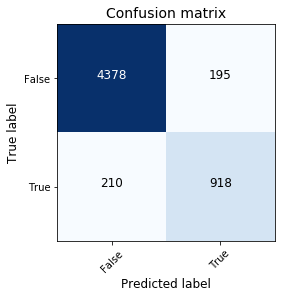

In [145]:
pretty_print_conf_matrix(y_true=test_y, y_pred=predicted_y, classes=["False", "True"])

In [146]:
rpt = classification_report(test_y, predicted_y)
print(rpt)

             precision    recall  f1-score   support

      False       0.95      0.96      0.96      4573
       True       0.82      0.81      0.82      1128

avg / total       0.93      0.93      0.93      5701

